In [1]:
%matplotlib inline

import numpy as np

import menpo.io as mio
from menpo.image import Image
from menpo.feature import ndfeature, greyscale, igo, no_op, centralize, normalize_norm, normalize_std
from menpo.visualize import visualize_images

from alaborticcv2015.deepconvkernel.generative import GenerativeLDCN, learn_pca_filters

# PCA Net 

In [47]:
folder_path = '/data/PhD/alaborticcv2015/'

Choose whether to work with color or greyscale images and whether to learn the filters from landmarks or regular grid:

In [128]:
@ndfeature
def grey_igo(pixels):
    pixels = greyscale(pixels)
    pixels = igo (pixels)
    return pixels

def grayscale(pixels):
    return greyscale(pixels, mode='average')

features = grayscale
landmarks = True 
n_layers = 2
architecture = 1
normalize_patches = centralize
normalize_filters = None

nf = 16
ps = 5

save_net = True

In [129]:
images = []
for i in mio.import_images('/data/PhD/DataBases/faces/lfpw/**/*', verbose=True, 
                           max_images=1000):
    i.crop_to_landmarks_proportion_inplace(0.5)
    i = i.rescale_landmarks_to_diagonal_range(100)
    i = features(i)
    images.append(i)

- Loading 1000 assets: [====================] 100%

Build a PCA Net:

In [130]:
net = GenerativeLDCN(learn_filters=learn_pca_filters, 
                     n_filters=n_filters, 
                     n_layers=n_layers,
                     architecture=architecture,
                     normalize_patches=centralize,
                     normalize_filters=normalize_filters,
                     patch_shape=(ps, ps))

if landmarks:
    net.learn_network_from_landmarks(images, group='PTS', verbose=True)
else:
    net.learn_network_from_grid(images, stride=(4, 4), verbose=True)

- Learning network
  - Layer 0: Done!
  - Layer 1: Done!


In [131]:
print '# of layers:', net.n_layers
print '# of filters:', net.n_filters
print '# of filters per layer:', net.n_filters_layer
print 'filters shape:', net.filters_shape

# of layers: 2
# of filters: 32
# of filters per layer: [16, 16]
filters shape: (5, 5)


Save network:

In [132]:
if save_net:
    file_name = (folder_path
                 + 'networks/pca_net/pca_net_3_1_' 
                 + str(nf) 
                 + '_' 
                 + str(ps)
                 + '.pkl.gz') 
    mio.export_pickle(net, file_name, overwrite=True)

Visualize the previous filters using the previous LinDeepConvNet:

In [133]:
filters = net.filters_spatial()

First layer spatial filters:

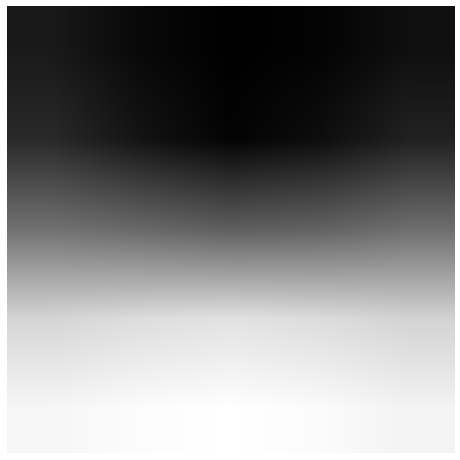

In [134]:
visualize_images(filters[0])

Second layer spatial filters:

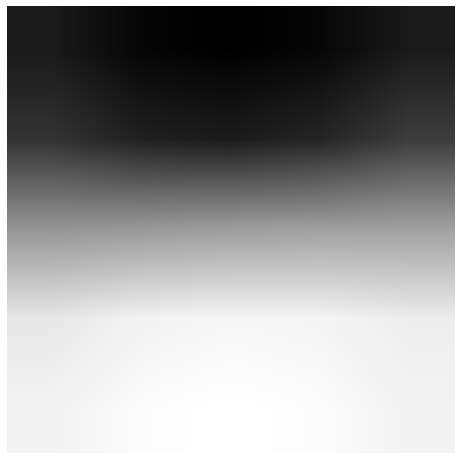

In [135]:
visualize_images(filters[1])

We can also visualize the previous filters on the frequency domain:

In [136]:
filters_frequecy = net.filters_frequency(ext_shape=(50, 50))

First layer filters in the frequency domain:

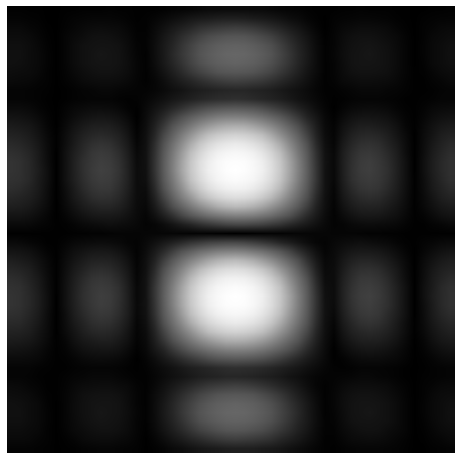

In [137]:
visualize_images(filters_frequecy[0])

Second layer filters in the frequency domain:

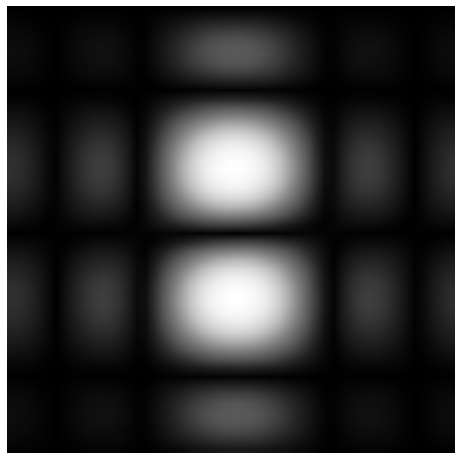

In [138]:
visualize_images(filters_frequecy[1])

Visualize Deep Convolutional Kernels:

In [139]:
kernels = net.kernels_spatial()

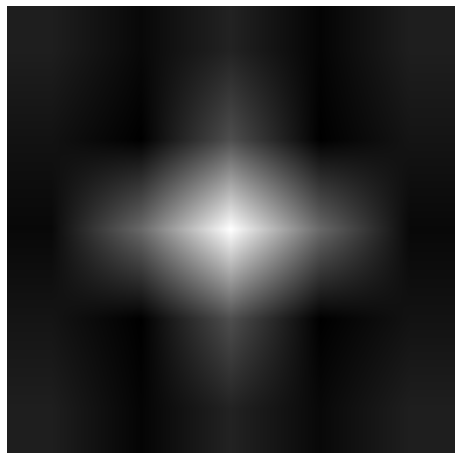

In [140]:
visualize_images(kernels)

In [141]:
kernels = net.kernels_frequency(ext_shape=(50, 50))

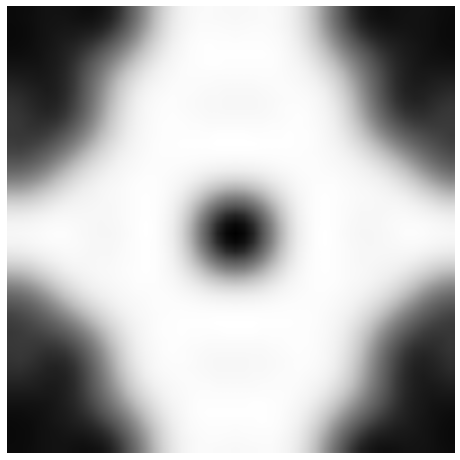

In [142]:
visualize_images(kernels)

Load images:

In [143]:
images = []
for i in mio.import_images('/data/PhD/DataBases/faces/lfpw/testset/', verbose=True, 
                           max_images=10):
    i.crop_to_landmarks_proportion_inplace(1)
    i = i.rescale_landmarks_to_diagonal_range(100)
    i = features(i)
    images.append(i)

- Loading 10 assets: [====================] 100%

Choose one of the previous images:

In [144]:
image = images[0]

Compute network features:

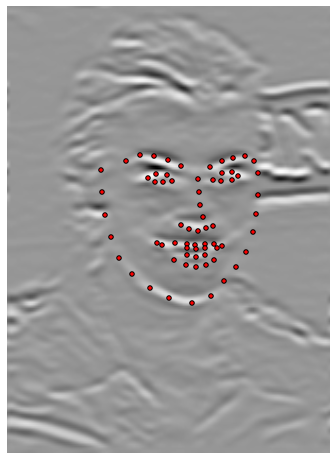

In [145]:
net.network_response(image).view_widget()

Compute deep convolutional kernel features:

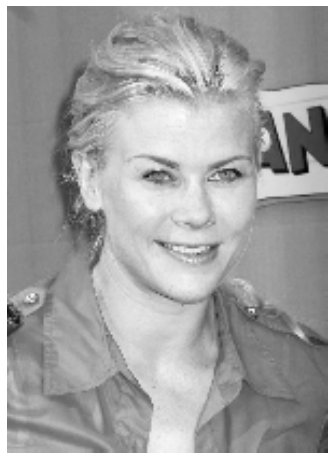

In [146]:
image.view()

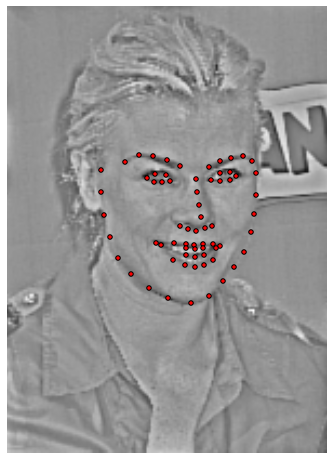

In [147]:
net.kernel_response(image, layer=0).view_widget()

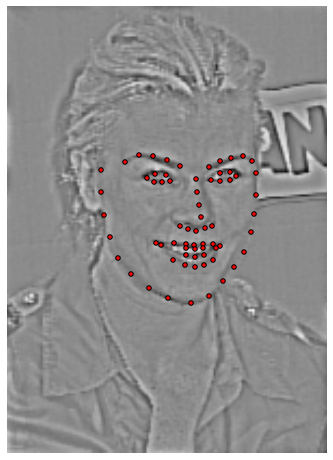

In [148]:
net.kernel_response(image, layer=1).view_widget()

Check Network and Kernel equivalence:

In [152]:
network_r = net.network_response(image, visible_mode='full', boundary='symmetric')
kernel_r = net.kernel_response(image, mode='full', boundary='symmetric')

print 'PCA Net features dot product:',  network_r.as_vector().dot(network_r.as_vector())
print 'PCA DCK features dot product:', kernel_r.as_vector().dot(kernel_r.as_vector())

PCA Net features dot product: 36288.2500646
PCA DCK features dot product: 37916.3155716


In [153]:
fft_image = np.fft.fft2(image.pixels) / np.sqrt(np.prod(image.shape[-2:]))

print 'PCA DCK Fourier dot product:', np.sum(net._compute_kernel(ext_shape=fft_image.shape[-2:]) * 
                                             fft_image.conj() * fft_image)

PCA DCK Fourier dot product: (37916.3155716-2.30483867363e-14j)
